<a href="https://colab.research.google.com/github/furk4neg3/Inception-GoogLeNet/blob/main/GoogLeNet_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoogLeNet Replication
In this notebook, I've replicated GoogLeNet - Inception paper. The report can be accessed from this link: https://arxiv.org/abs/1409.4842

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()# No worries, I've expired my API token before loading the model to GitHub.

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"furkanegecannizam","key":"110d60a39722b40e9518d8fcd1116907"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [90]:
!kaggle datasets download -d gpiosenka/100-bird-species

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/100-bird-species
License(s): CC0-1.0
 99% 1.94G/1.96G [00:11<00:00, 188MB/s]
100% 1.96G/1.96G [00:11<00:00, 183MB/s]


## Dataset
GoogLeNet is mainly used for image classification problem, so I've used an image classification dataset, which involves bird species, only because I like birds. This model can be used for other image classification problems too.

In [91]:
! unzip 100-bird-species.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: train/WHITE TAILED TROPIC/120.jpg  
  inflating: train/WHITE TAILED TROPIC/121.jpg  
  inflating: train/WHITE TAILED TROPIC/122.jpg  
  inflating: train/WHITE TAILED TROPIC/123.jpg  
  inflating: train/WHITE TAILED TROPIC/124.jpg  
  inflating: train/WHITE TAILED TROPIC/125.jpg  
  inflating: train/WHITE TAILED TROPIC/126.jpg  
  inflating: train/WHITE TAILED TROPIC/127.jpg  
  inflating: train/WHITE TAILED TROPIC/128.jpg  
  inflating: train/WHITE TAILED TROPIC/129.jpg  
  inflating: train/WHITE TAILED TROPIC/130.jpg  
  inflating: train/WHITE TAILED TROPIC/131.jpg  
  inflating: train/WHITE TAILED TROPIC/132.jpg  
  inflating: train/WHITE TAILED TROPIC/133.jpg  
  inflating: train/WHITE TAILED TROPIC/134.jpg  
  inflating: train/WHITE TAILED TROPIC/135.jpg  
  inflating: train/WHITE TAILED TROPIC/136.jpg  
  inflating: train/WHITE TAILED TROPIC/137.jpg  
  inflating: train/WHITE TAILED TROPIC/138.jpg  
  inflating: train/WHI

There are 3 examples from the dataset to understand the data that we're working on.

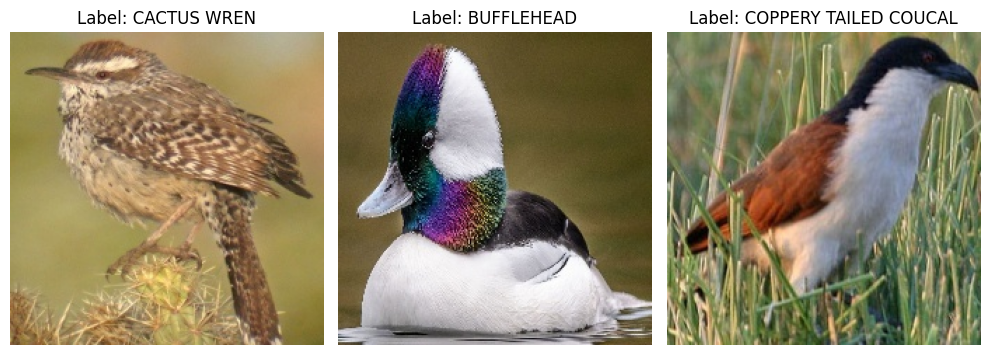

In [151]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the test data directory path
test_data_dir = '/content/test'

# List all the label directories
label_dirs = [os.path.join(test_data_dir, d) for d in os.listdir(test_data_dir) if os.path.isdir(os.path.join(test_data_dir, d))]

# Randomly select a few labels
selected_labels = random.sample(label_dirs, 3)  # Choose 3 random labels

# Plot images from the selected labels
plt.figure(figsize=(10, 10))

for i, label_dir in enumerate(selected_labels):
    # List all images in the label directory
    image_files = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(('jpg', 'jpeg', 'png'))]

    # Select a random image from the label directory
    random_image_file = random.choice(image_files)

    # Read and display the image
    img = mpimg.imread(random_image_file)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {os.path.basename(label_dir)}")
    plt.axis('off')

plt.tight_layout()
plt.show()


I've prepared data to fit in the network. Augmented training samples to prevent overfitting, prefetched every dataset for the model to work faster.

In [114]:
import tensorflow as tf
import numpy as np

# Define paths to datasets
train_dir = '/content/train'
val_dir = '/content/valid'
test_dir = '/content/test'

# Set parameters
batch_size = 32
img_size = (224, 224)
seed = 42

# Load datasets with categorical label mode, that will result in one hot encoded labels
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True
)

# Data augmentation function
def augment_data(image, label):
    # Rescale images to [0, 1] range
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Randomly apply data augmentations
    image = tf.image.random_flip_left_right(image)# Randomly flip images left and right
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))# Randomly rotate images
    image = tf.image.random_brightness(image, 0.2)# Randomly shift images horizontally and vertically by 20%
    image = tf.image.random_flip_up_down(image)# Randomly flip images up and down

    return image, label

# Apply data augmentation to the train dataset
train_dataset = train_dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch data for performance optimization
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Verify the dataset shapes
for images, labels in train_dataset.take(1):
    print(f'Image batch shape: {images.shape}')
    print(f'Label batch shape: {labels.shape}')

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 525)


Only used 10 percent of the data, because I wanted to train the model faster. Because it has 22 layers with parameters and overfitting is prevented as the paper says, using more data will give better results.

In [148]:
# Taking 10% of the train data.
total_samples = len(train_dataset) * 32
ten_percent_samples = int(total_samples * 0.1)
ten_percent_batches = ten_percent_samples // 32
train_data_10_percent = train_dataset.take(ten_percent_batches)

# Inception Block
That is the block to create GoogLeNet. It gets one input, which is another layer's output, then divides to 4 different paths which all contains Conv2D layers, then concatenates these paths' outputs. Further information, like the reason of having 1x1 Conv2D layers before 3x3 and 5x5 layers, can be found in the paper.

**❗Very important detail:**  As you can see, weight intialization method is changed to **glorot_uniform**. TensorFlow's standard weight intialization method doesn't work on that model, when it's not changed to **glorot_uniform**, model won't train.

In [136]:
def Inception(input_layer, kernel_1, kernel_3_reduce, kernel_3, kernel_5_reduce, kernel_5, kernel_1_after_pooling):
  # First path
  first_path = layers.Conv2D(filters=kernel_1, kernel_size=(1,1), activation='relu', kernel_initializer='glorot_uniform')(input_layer)

  # Second path
  second_path = layers.Conv2D(filters=kernel_3_reduce, kernel_size=(1,1), padding='same', activation='relu', kernel_initializer='glorot_uniform')(input_layer)
  second_path = layers.Conv2D(filters=kernel_3, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='glorot_uniform')(second_path)

  # Third path
  third_path = layers.Conv2D(filters=kernel_5_reduce, kernel_size=(1,1), padding='same', activation='relu', kernel_initializer='glorot_uniform')(input_layer)
  third_path = layers.Conv2D(filters=kernel_5, kernel_size=(5,5), padding='same', activation='relu', kernel_initializer='glorot_uniform')(third_path)

  # Fourth path
  fourth_path = layers.MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(input_layer)
  fourth_path = layers.Conv2D(filters=kernel_1_after_pooling, kernel_size=(1,1), activation='relu', kernel_initializer='glorot_uniform')(fourth_path)

  # Concatenate all paths' outputs
  output = layers.concatenate([first_path, second_path, third_path, fourth_path], axis=-1)

  return output

# GoogLeNet Model
Every parameter is taken from the paper, instead of local_response_normalization layer. I couldn't find any information about this layer in the paper, so I've used the most used parameters.

In [137]:
input = layers.Input(shape=(224,224,3))
x = layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu', kernel_initializer='glorot_uniform')(input)
x = layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
x = tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)

x = layers.Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='valid', activation='relu', kernel_initializer='glorot_uniform')(x)
x = layers.Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu', kernel_initializer='glorot_uniform')(x)

x = tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)
x = layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(x)

x = Inception(x, 64, 96, 128, 16, 32, 32)
x = Inception(x, 128, 128, 192, 32, 96, 64)
x = layers.MaxPooling2D(pool_size=(3,3), strides=2)(x)
x = Inception(x, 192, 96, 208, 16, 48, 64)# In the paper, after that Inception block, there is a auxiliary classifier, to prevent vanishing gradients problem. Model still works
# well without it and it's easier to understand, so I didn't add it here.

x = Inception(x, 160, 112, 224, 24, 64, 64)
x = Inception(x, 128, 128, 256, 24, 64, 64)
x = Inception(x, 112, 144, 288, 32, 64, 64)
x = Inception(x, 256, 160, 320, 32, 128, 128)# In the paper, after that Inception block, there is a auxiliary classifier, to prevent vanishing gradients problem. Model still works
# well without it and it's easier to understand, so I didn't add it here.

x = layers.MaxPooling2D(pool_size=(3,3), strides=2)(x)
x = Inception(x, 256, 160, 320, 32, 128, 128)
x = Inception(x, 384, 192, 384, 48, 128, 128)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
output = layers.Dense(525, activation='softmax', kernel_initializer='glorot_uniform')(x)# 525 is output size because the dataset that I used has 525 classes, change if needed.

GoogLeNet = tf.keras.Model(inputs=input, outputs=output, name='GoogLeNet')

Again, paper mentions that they used ASGD with those parameters and learning rate schedules like this, but because I couldn't find ASGD in TensorFlow, I used an SGD instead with all other parameters staying the same.

In [144]:
def learning_rate_schedule(epoch, lr):
    # Decrease the learning rate by 4% every 8 epochs
    if epoch > 0 and epoch % 8 == 0:
        return lr * 0.96
    return lr


initial_learning_rate = 0.01  # Starting learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate, momentum=0.9)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule, verbose=1)

Loss function is different from the paper because they submitted this model to a competetion and their challenge was different. But for normal classification problem, categorical_crossentropy works really well for multi label classification.

❗Training stopped by keyboard interrupt (which means, by me) at 31st epoch. That's because it's already obvious here that model gets better with nearly every epoch. And if we use more data (like all of the training samples), model will get much better. But because I don't have that much time, I've interrupted the training.

In [146]:
GoogLeNet.compile(optimizer=optimizer,
                   loss="categorical_crossentropy",
                   metrics=["accuracy"])# Metrics can be changed, I chose accuracy because it's easier to understand.

GoogLeNet.fit(train_data_10_percent,# Whole data can be used.
              epochs=100,# Can train for longer.
              steps_per_epoch=len(train_data_10_percent),
              validation_data=val_dataset,
              validation_steps=len(val_dataset),# Can decrease the validation steps to speed up the training process, I wanted to see accurate val_accuracy results so used all
              # of validation data.
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", restore_best_weights=True, patience=10),# When the val_accuracy stops increasing for 10 epochs,
                         #training will finish. Can change the patience or monitor here.
                         lr_scheduler])# I've set up lr_schedular in the upper block.


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/100
264/264 [==============================] - 174s 643ms/step - loss: 6.2525 - accuracy: 0.0033 - val_loss: 6.2651 - val_accuracy: 0.0019 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/100
264/264 [==============================] - 170s 641ms/step - loss: 6.2507 - accuracy: 0.0032 - val_loss: 6.2671 - val_accuracy: 0.0019 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/100
264/264 [==============================] - 172s 649ms/step - loss: 6.2458 - accuracy: 0.0032 - val_loss: 6.2705 - val_accuracy: 0.0019 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/100
264/264 [==============================] - 172s 650ms/step - loss: 6.2434 - accuracy: 0.0036 - val_loss: 6.2730 - val_accuracy: 0.0019 - lr: 0.0100

Epoch 5: LearningRateScheduler setting lear

KeyboardInterrupt: 

That's only an example of accuracy. It can be seen above that accuracy was increasing very fast, which means leaving the model to train more is going to give much better resutls. At the same time, more data can be used, and this will result in better results too (the model in the paper has been trained on ImageNet with 1.2 million images).

In [156]:
GoogLeNet.evaluate(test_dataset)

83/83 [==============================] - 12s 136ms/step - loss: 4.8084 - accuracy: 0.0701


[4.808368682861328, 0.0700952410697937]